因为经常要计算 CAR，所以写了一个脚本，支持市场模型和三因子模型，测试数据都来自于国泰安数据库，视频介绍在 [b 站](https://www.bilibili.com/video/BV1Rp4y1m7Wt/?spm_id_from=333.999.0.0)。

脚本的核心是 `EventStudy` 类。下面是一个简单的例子：

```Python
import eventstudy

es_market_model = eventstudy.EventStudy(
    sample_market_model,  # 事件样本
    "Market",  # 正常收益率估计模型
    market_model_data, # 估计模型所需数据
    daily_stock_returns,  # 个股历史回报率
    -1,  # t1
    30,  # t2
    10,  # span
    200  # 估计期长度
)
```


# 市场模型

$$R_{it} = \alpha_i + \beta_iR_{Mt} + \varepsilon_{it}$$

$R_{it}$ 表示公司 $i$ 在第 $t$ 个交易日的考虑现金红利再投资的个股回报率，$R_{Mt}$ 表示第 $t$ 个交易日公司所在分市场的市场回报率，等于考虑现金红利再投资的日市场回报率（流通市值加权平均法）。


In [1]:
import pandas as pd
import eventstudy

In [2]:
daily_stock_returns = pd.read_csv(
    "./data/daily_stocks_returns.csv", dtype={"ticker": str}
)

`daily_stock_returns` 是个股历史回报率，注意个股历史回报率需要包含如下测试字段，即 ticker、TradingDate 和 return，分别代表股票代码、交易日和个股回报率。


In [3]:
daily_stock_returns.head()

,ticker,TradingDate,return
0,000001,2013-11-29,-0.001468
1,000001,2013-12-02,0.011029
2,000001,2013-12-03,-0.015273
3,000001,2013-12-04,0.004431
4,000001,2013-12-05,-0.012500


In [4]:
sample_market_model = pd.read_csv(
    "./data/sample_for_marketmodel.csv", dtype={"ticker": str}
)

`sample_market_model` 是事件样本，注意事件样本需要包含如下测试字段，即 EventDate、ticker 和 MarketTypeID，分别代表事件日、股票代码和市场类型。


In [5]:
sample_market_model.head()

,EventDate,ticker,MarketTypeID
0,2016-04-21,002177,4
1,2016-11-10,300188,16
2,2018-01-12,300002,16
3,2018-01-15,000935,4
4,2018-01-15,000021,4


`market_model_data` 是市场模型所需要的数据，注意市场模型数据需要包含如下测试字段，即 MarketTypeID、TradingDate 和 market_returns，分别代表市场类型、交易日和市场收益率。


In [6]:
market_model_data = pd.read_csv("./data/market_model_data.csv")

In [7]:
market_model_data.head()

,MarketTypeID,TradingDate,market_returns
0,1,1990-12-19,NaN
1,1,1990-12-20,0.050067
2,1,1990-12-21,0.039671
3,1,1990-12-24,0.049380
4,1,1990-12-25,0.049938


In [8]:
es_market_model = eventstudy.EventStudy(
    sample_market_model.head(10),
    "Market",
    market_model_data,
    daily_stock_returns,
    -1,
    30,
    10,
    200,
)

In [9]:
res_market_model = es_market_model.get_result()

Tasks finished: 100%

`get_result()` 返回一个字典，字典中包含样本 CAR、CAR 的描述性统计结果、剔除的样本和剩余样本。


In [10]:
res_market_model.keys()

dict_keys(['describe_res', 'sample_removed', 'sample_remained', 'sample_cars'])

In [11]:
res_market_model["sample_remained"]

,EventDate,ticker,MarketTypeID
0,2016-04-21,002177,4
1,2016-11-10,300188,16
2,2018-01-12,300002,16
3,2018-01-15,000935,4
4,2018-01-15,000021,4
5,2018-01-30,300108,16
6,2018-04-05,600602,1
7,2018-12-11,300356,16
8,2019-05-08,300427,16
9,2019-07-02,000917,4


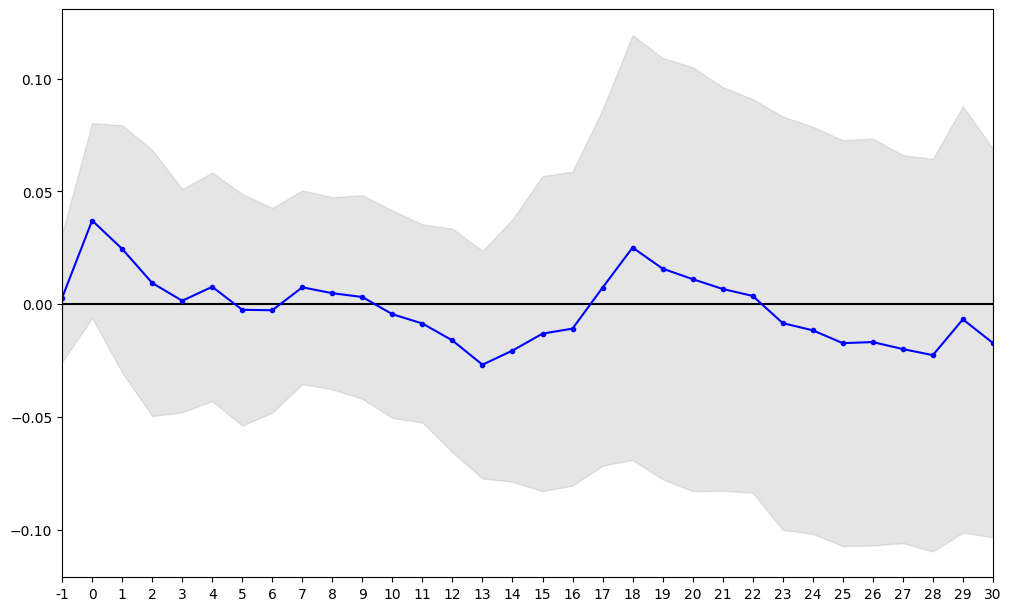

In [12]:
eventstudy.res_plot(re_market_model["sample_cars"], 0.90)

# 三因子模型

$$R_{it} - R_{ft} = \alpha_i + b_i(R_{Mt}-R_{ft}) + s_iSMB_t + h_iHML_t + \varepsilon_it$$


In [13]:
famafrench_factors = pd.read_csv("./data/famafrench_factors_data.csv")

`famafrench_factors` 是三因子模型数据，注意三因子数据需要包含如下测试字段，即 MarketTypeID、TradingDate、RiskPremium、SMB、HML 和 risk_free_rate，分别代表市场类型、交易日、风险溢价因子、SMB、HML 和无风险利率。


In [14]:
famafrench_factors.head()

,MarketTypeID,TradingDate,RiskPremium,SMB,HML,risk_free_rate
0,P9706,1990-12-19,2.473374,NaN,NaN,0.0227
1,P9710,1990-12-19,2.473374,NaN,NaN,0.0227
2,P9709,1990-12-19,2.473374,NaN,NaN,0.0227
3,P9712,1990-12-19,2.473374,NaN,NaN,0.0227
4,P9713,1990-12-19,2.473374,NaN,NaN,0.0227


In [15]:
sample_famafrench = pd.read_csv("./data/sample.csv", dtype={"ticker": str})

`sample_famafrench` 是事件样本，与前述要求一致，需要包含如下测试字段。


In [16]:
sample_famafrench.head()

,EventDate,ticker,MarketTypeID
0,2016-04-21,002177,P9706
1,2016-11-10,300188,P9705
2,2018-01-12,300002,P9705
3,2018-01-15,000935,P9706
4,2018-01-15,000021,P9706


In [17]:
es_famafrench = eventstudy.EventStudy(
    sample_famafrench.head(10),
    "FamaFrench",
    famafrench_factors,
    daily_stock_returns,
    -1,
    30,
    10,
    200,
)

In [18]:
res_famafrench = es_famafrench.get_result()

Tasks finished: 100%

In [19]:
res_famafrench.keys()

dict_keys(['describe_res', 'sample_removed', 'sample_remained', 'sample_cars'])

In [20]:
res_famafrench["describe_res"]

,count,mean,std,min,25%,50%,75%,max,t-statstics,p-value
-1,10.0,0.005946,0.050654,-0.042915,-0.026691,-0.008127,0.004223,0.102982,0.371196,0.719079
0,10.0,0.042546,0.074948,-0.035565,-0.010073,0.022935,0.060273,0.202987,1.795155,0.106202
1,10.0,0.031981,0.093752,-0.069651,-0.007391,-0.003999,0.021624,0.263352,1.078718,0.308774
2,10.0,0.013060,0.103207,-0.101936,-0.029064,-0.023455,0.024744,0.232986,0.400162,0.698369
3,10.0,0.004802,0.087637,-0.130160,-0.043901,-0.016113,0.064789,0.143388,0.173265,0.866277
4,10.0,0.009385,0.090681,-0.128522,-0.046949,-0.022871,0.092813,0.147597,0.327286,0.750935
5,10.0,0.001967,0.089825,-0.153967,-0.036466,-0.013752,0.072597,0.134979,0.069254,0.946301
6,10.0,0.002818,0.083841,-0.180795,-0.027049,0.003889,0.059211,0.121202,0.106300,0.917676
7,10.0,0.012787,0.080665,-0.159540,-0.014551,0.020998,0.050448,0.150747,0.501306,0.628188
8,10.0,0.008737,0.082093,-0.163451,-0.025143,0.023856,0.041238,0.142756,0.336549,0.744171


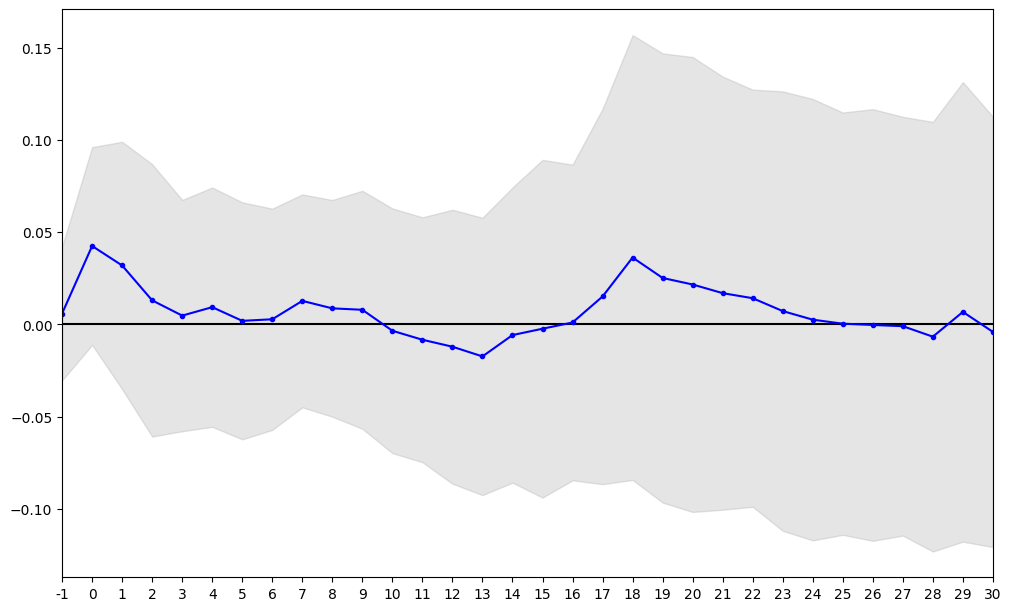

In [21]:
eventstudy.res_plot(res_famafrench["sample_cars"])